# Lesson 1: Optimization

This notebook illustrates optimization, the central feature of all of machine learning. As a concrete physics-based example, it shows how to find the shape of a mechanical structure by minimizing its energy via gradient descent. In this context, it illustrates the most powerful aspect of ```jax```, namely automatic differentiation via ```grad```.

(C) 2024 Florian Marquardt, Max Planck Institute for the Science of Light (MIT License)

## Imports

First perform useful imports: ```matplotlib``` for plotting, ```jax.numpy``` as a replacement for standard ```numpy```, and ```grad``` from ```jax``` to calculate gradients of functions:

In [4]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import jax.numpy as jnp
from jax import grad

## Defining the energy of a mechanical structure

Our goal is to find the equilibrium shape of a chain that is suspended and under the pull of gravity.


![ ](chain_figure.jpg)


To model this situation, we define the potential energy of a chain of masses connected by springs. The masses are located at positions that are equally spaced (by 1) in the horizontal direction but located at positions $y_j$ in the vertical (height) direction. Using Pythagoras, we arrive at:

$$
E = \sum_{j=0}^{N-1} {K \over 2} \left(\sqrt{ (y_{j+1}-y_j)^2 + 1 } - l\right)^2
$$

Here $K$ is the spring constant, called ```spring``` in the following, and $l$ is the equilibrium length of each spring, called ```length```.

We also add the contribution of a gravitational potential energy:

$$
E_{\rm grav} = \sum_{j=0}^N m g y_j
$$

We set $mg$ to ```mass_g```.

In [5]:
def E(y,spring,length,mass_g):
    """
    Calculate the energy.
    
    y : array containing vertical coordinates, evaluated at x = 0, 1, 2, ...
    spring : spring constant
    length : equilibrium length
    mass_g : mass times g for an individual mass
    """
    
    spring_energy = jnp.sum( 0.5*spring * ( jnp.sqrt((y[1:]-y[:-1])**2 + 1) - length )**2 )
    
    # add contributions from beginning and end (fixed boundaries!):
    spring_energy += 0.5*spring * ( jnp.sqrt(y[0]**2 + 1) - length )**2
    spring_energy += 0.5*spring * ( jnp.sqrt(y[-1]**2 + 1) - length )**2
    
    gravitational_energy = mass_g * jnp.sum(y)
    
    return spring_energy + gravitational_energy
        

```{admonition} Little trick
Since we want to keep the boundaries fixed, at 0 height, we separately added the spring energies of the springs connected to the left and right boundary.
```

## Taking the gradient of the energy

Now we for the first time exploit the power of ```jax```. We simply call ```grad``` on the function ```E```, telling it to take the derivative of ```E``` with respect to its first argument, which is the array of heights ```y```. This produces a new function, here called ```grad_E```, which has the same arguments as E but now will return the gradient of ```E``` with respect to ```y```. Note that this gradient is a vector, while ```E``` itself was a scalar function.

In [6]:
# Produce the function that calculates the gradient of E
# with respect to the y argument (argument number 0):

grad_E = grad(E, argnums = 0)

## Some words on functional programming

In order for ```jax``` to be able to take the gradient, you have to write a function that essentially behaves like a mathematical function. This means you have to respect the rules of "functional programming". Note that mathematical functions have no side effects: you always get the same result when you evaluate ```sin(3.5)```, and the act of evaluating ```sin``` does not change anything else in the world. Therefore, in functional programming functions are not allowed to have any side effects. A function cannot access or change global variables or modify its arguments (which otherwise would be possible in python, since arrays are passed via reference!). This is enforced strictly in true functional programming languages, but in python it is a choice that you have to make yourself.

In addition to the constraints of functional programming, there are a few further rules. For example, everything should be done with array syntax instead of for loops, for efficiency. Conditionals ("if" statements) are not allowed, but can usually be replaced using array expressions like ```(x<0)*(x**2) + (x>=0)*(x+3)```. And you cannot simply assign values to an individual array entry, at least not using standard syntax. Again, if you write a function that behaves like a normal mathematical function, these issues will not come up.

## Gradient descent loop

We now perform gradient descent. This means running a loop. In each iteration of this loop we  calculate the gradient of ```E```, then subtract it from the current values of the chain shape ```y```, so as to lower the energy, and continue with this process. In order to not make overly large steps, we define a stepsize ```eta``` that is multiplied with the gradient before doing the subtraction. Larger stepsizes would result in quicker convergence, but if it gets too large, the process is unstable.

We finally plot all the chain shapes in a single plot, to observe how the chain tries to relax to its equilibrium shape under the influence of both the springs and gravity.

In [7]:
# Physics parameters:
N = 20 # number of masses in the chain
spring = 5.0 # spring constant
length = 0.8 # springs are stretched even when chain is straight!
mass_g = 0.1 # m*g for each mass

# Initialization:
y = jnp.zeros(N) # initially, all masses at y=0

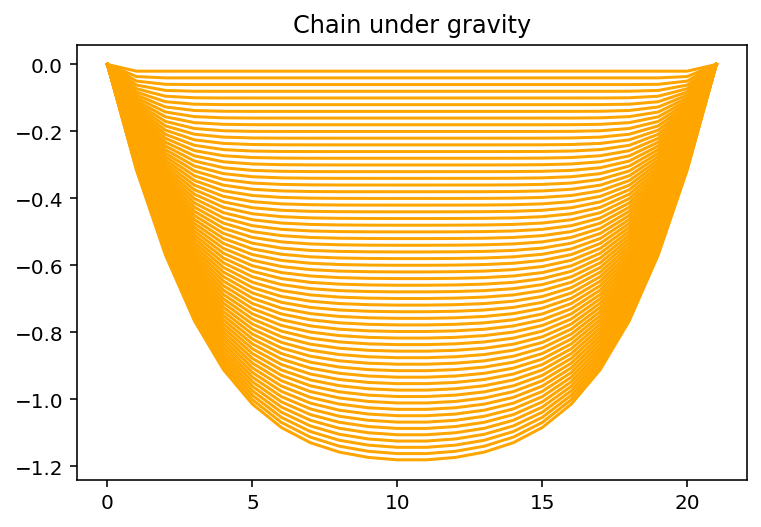

In [8]:
# Now do several steps of gradient descent:

# Gradient descent steps:
nsteps = 60 # number of gradient descent steps
eta = 0.2 # size of each gradient descent step

zero = jnp.array([0.0]) # needed for plotting

for step in range(nsteps):
    y -= eta * grad_E(y, spring, length, mass_g)
    plt.plot(jnp.concatenate([zero,y,zero]), color="orange") # plot with boundaries appended

plt.title("Chain under gravity")
plt.show()


## Adaptive-stepsize gradient descent using optax

We are now getting a bit more sophisticated. We will use the ```optax``` library to perform gradient descent using an adaptive stepsize. ```optax``` is the standard gradient-descent library used alongside ```jax```. In particular, we will use the famous ```adam``` technique which has become a default adaptive-stepsize approach for machine learning.

In [9]:
import optax

Let us initialize our chain shape and initialize the ```optimizer``` that will help us do the adaptive stepsize gradient descent.

In [10]:
# Initialization:
y = jnp.zeros(N) # initially, all masses at y=0

# the gradient step size is called "learning rate"
# in machine learning language:
learning_rate = 0.1

# get the optimizer:
optimizer = optax.adam( learning_rate )
# initialize the 'state' of the optimizer, by
# telling it about the initial values:
opt_state = optimizer.init( y )

Now let us again perform gradient descent, but using ```adam```. In each step, the gradients ```grads``` are calculated, just like before. However, now they are used to calculate the ```updates``` using the optimizer, while also updating the internal optimizer state ```opt_state```. This internal state is needed to keep track of things like averages over the size of past gradients, to be able to adapt the gradient stepsize.

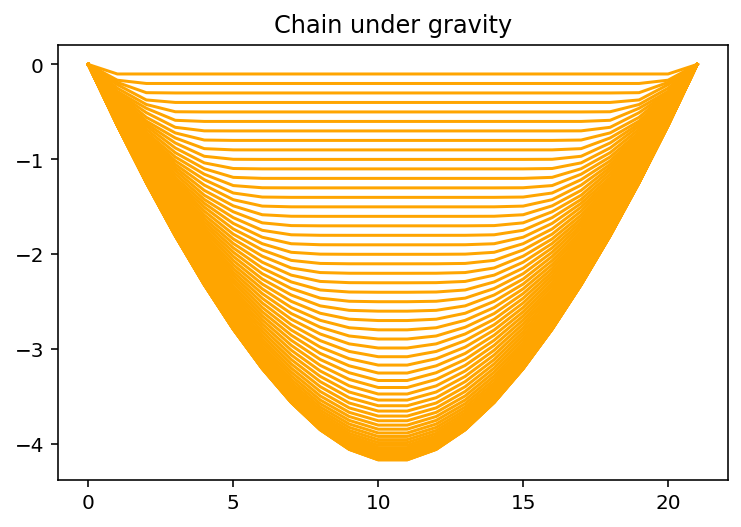

In [11]:
# Gradient descent steps:
nsteps = 60 # number of gradient descent steps

zero = jnp.array([0.0])

for step in range(nsteps):
    # get gradients:
    grads = grad_E(y, spring, length, mass_g)
    
    # update y using the gradients:
    updates, opt_state = optimizer.update( grads, opt_state)
    y = optax.apply_updates( y, updates )
    
    plt.plot(jnp.concatenate([zero,y,zero]), color="orange") # plot with boundaries appended

plt.title("Chain under gravity")
plt.show()

We see that in the same number of steps, the chain is now actually converged to its final equilibrium shape, which was not yet the case before!

```{admonition} Exercise
If you are interested in playing with the physics of this example, try changing the equilibrium spring length and run the gradient descent again (interesting values are 1 and also values above 1).
```

```{admonition} Outlook
optax offers many more choices for the optimizer beyond "adam". In addition, it allows useful things like changing the overall stepsize (or "learning rate") as a function of time.
```